# Вычисление центральностей у графа из друзей и друзей друзей в социальной сети ВК

Работу выполнили студенты группы БСМО-11-25:

* Аршинов Владислав (VK ID: `488243736`)
* Елохин Валерий (VK ID: `340121125`)
* Савин Даниил (VK ID: `326866301`)
* Якушенко Иван (VK ID: `219305476`)



In [1]:
# Список VK ID авторов работы
CONTRIBUTORS = {488243736:"Аршинов Владислав", 340121125:"Елохин Валерий", 326866301:"Савин Даниил", 219305476:"Якушенко Иван"}

-----
Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque, defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
import warnings

Загружаем данные

In [3]:
data = pd.read_csv('friends.csv', encoding='utf-8')
data

,source,target
0,257465738,325184625
1,466889037,244171350
2,549033684,507018881
3,275013962,318904929
4,180398332,563809421
...,...,...
157920,244704883,229878628
157921,135883377,120062407
157922,294291839,268371693
157923,852669061,549654374


Убираем дубликаты строк в данных

In [4]:
# Создаем столбец с отсортированными парами для идентификации дубликатов
data['sorted_pair'] = data.apply(lambda row: ','.join(sorted([str(row['source']), str(row['target'])])), axis=1)

# Удаляем дубликаты по отсортированным парам, сохраняя первую встреченную строку
data = data.drop_duplicates(subset=['sorted_pair'])

# Удаляем временный столбец
data = data.drop('sorted_pair', axis=1)
data

,source,target
0,257465738,325184625
1,466889037,244171350
2,549033684,507018881
3,275013962,318904929
4,180398332,563809421
...,...,...
157920,244704883,229878628
157921,135883377,120062407
157922,294291839,268371693
157923,852669061,549654374


## Центральность по собственному вектору

Алгоритм центральности по собственному вектору определяет важность вершины на основе важности её соседей.

Вершина считается тем более влиятельной, чем больше у неё связей с другими важными вершинами. Это рекурсивное понятие: важная вершина связана с другими важными вершинами. Математически это соответствует нахождению главного собственного вектора матрицы смежности графа, где каждая компонента вектора представляет центральность соответствующей вершины.

Проще говоря: "важность вершины = средняя важность её соседей".

Для начала, воспользуемся готовой библиотечной реализацией алгоритма, чтобы был ориентир

In [5]:
G = nx.from_pandas_edgelist(data)
centralities_lib = nx.eigenvector_centrality(G,10000)
centralities_lib

{257465738: 8.866589620593904e-05,
 325184625: 1.4581773331771778e-06,
 466889037: 6.542433973615769e-05,
 244171350: 1.0747029181584424e-06,
 549033684: 0.00018114524853450235,
 507018881: 3.145800595471576e-06,
 275013962: 0.0005836880951745041,
 318904929: 9.661489771289317e-06,
 180398332: 0.00016276765932920554,
 563809421: 2.6295005352598743e-06,
 13588275: 0.0005132458987204103,
 304054: 8.759667636234302e-06,
 207634257: 0.0008027259254396652,
 161567229: 1.3049932260481452e-05,
 456925212: 0.0035051160166180025,
 171768717: 6.12745011153805e-05,
 299908306: 0.0005430571438005654,
 214097082: 9.261058115619208e-06,
 166627739: 0.0021907344518668766,
 284260287: 3.5848724807702545e-05,
 257066830: 0.0002806325665450096,
 323878902: 5.0171719782956136e-05,
 516146289: 0.006049455573372721,
 283228802: 0.0004618514374124623,
 456494191: 0.009654864550444524,
 823336: 0.00015966771365449867,
 548097163: 4.9436019694013956e-05,
 76216251: 0.0003546836872051584,
 619577615: 6.4106100

Теперь создадим свою реализацию и прогоним данные через нее

In [6]:
def eigenvector_centrality(df, max_iter=100, tol=1e-6):
    """
    Оптимизированная версия с экономией памяти
    """
    # Используем более эффективное создание mapping
    unique_nodes = np.union1d(df['source'].unique(), df['target'].unique())
    node_to_idx = {node: i for i, node in enumerate(unique_nodes)}
    n = len(unique_nodes)

    # Строим матрицу смежности более эффективно
    sources = df['source'].map(node_to_idx).values
    targets = df['target'].map(node_to_idx).values

    # Создаем разреженную матрицу
    A = csr_matrix((np.ones(len(sources), dtype=np.float32),
                   (sources, targets)), shape=(n, n))

    # Для неориентированного графа - делаем симметричной
    A = A + A.T
    A.data = np.ones_like(A.data)  # Убираем веса, оставляем только факт связи

    # Оптимизированный степенной метод
    n = A.shape[0]
    x = np.ones(n, dtype=np.float32) / n  # Начальное приближение

    for i in range(max_iter):
        # Умножение разреженной матрицы на вектор
        Ax = A.dot(x)

        # Нормализация
        norm = np.sqrt(np.dot(Ax, Ax))  # L2 норма

        if norm < 1e-12:
            break

        x_new = Ax / norm

        # Проверка сходимости
        if np.sqrt(np.dot(x_new - x, x_new - x)) < tol:
            x = x_new
            print(f"Сходимость достигнута на итерации {i+1}")
            break

        x = x_new

    centrality = np.abs(x)
    # centrality = centrality / centrality.sum()  # Нормализация

    return dict(zip(unique_nodes, centrality))

In [7]:
centralities_custom = eigenvector_centrality(data, 10000)
centralities_custom

Сходимость достигнута на итерации 121


{np.int64(753): np.float32(2.6518899e-06),
 np.int64(2202): np.float32(0.0006390248),
 np.int64(2617): np.float32(2.4321562e-06),
 np.int64(2827): np.float32(9.64644e-07),
 np.int64(4492): np.float32(0.00017027833),
 np.int64(5005): np.float32(0.00017027833),
 np.int64(5286): np.float32(1.3540538e-06),
 np.int64(5523): np.float32(2.7719225e-06),
 np.int64(5792): np.float32(1.38198775e-05),
 np.int64(6945): np.float32(0.0006390248),
 np.int64(6962): np.float32(0.0009348703),
 np.int64(7361): np.float32(0.0024123755),
 np.int64(7751): np.float32(0.0045740074),
 np.int64(8236): np.float32(0.00017027833),
 np.int64(8791): np.float32(2.0779603e-06),
 np.int64(11105): np.float32(0.00017027833),
 np.int64(11946): np.float32(1.6762475e-06),
 np.int64(12022): np.float32(1.38198775e-05),
 np.int64(13121): np.float32(1.38198775e-05),
 np.int64(13311): np.float32(1.38198775e-05),
 np.int64(14195): np.float32(1.7281377e-06),
 np.int64(14603): np.float32(2.0142816e-05),
 np.int64(14739): np.float32(

Центральности авторов работы согласно библиотечной функции:

In [8]:
for user_id, user_name in CONTRIBUTORS.items():
  print(f"{user_name} -> {centralities_lib[user_id]}")

Аршинов Владислав -> 0.005071561707705584
Елохин Валерий -> 0.003934351810307029
Савин Даниил -> 0.0030236107263510495
Якушенко Иван -> 0.0713404974960948


Центральности авторов работы согласно самодельной функции:

In [9]:
for user_id, user_name in CONTRIBUTORS.items():
  print(f"{user_name} -> {centralities_custom[user_id]}")

Аршинов Владислав -> 0.004431428387761116
Елохин Валерий -> 0.003566188272088766
Савин Даниил -> 0.002726529724895954
Якушенко Иван -> 0.07114899158477783


Значения центральности совпадают с незначительными погрешностями

Последующие алгоритмы требуют очень много времени на выполнение. По нашим оценкам, обработка полного объема данных займет более 2,5 суток. С учетом этого, для последующих алгоритмов было принято решение использовать ограниченную выборку из авторов данной работы, их непосредственных друзей и еще 1000 наиболее центральных пользователей, согласно результатам вышеприведенного алгоритма.

In [10]:
central_users = set(CONTRIBUTORS.keys()) | set(data[data["source"].isin(CONTRIBUTORS.keys())]["target"])
count = 0
for u, _ in sorted([(k, v) for k, v in centralities_custom.items()], key=lambda p: p[1], reverse=True):
  if u not in central_users:
    central_users.add(u)
    count += 1
    if count == 1000:
      break
data = data[data["source"].isin(central_users)]
data = data[data["target"].isin(central_users)]
data

,source,target
55,662741463,25891559
70,9030558,2774402
72,181226986,476551834
79,333156814,612347251
123,172710559,488243736
...,...,...
157864,333156814,339526172
157867,9030558,169659848
157879,267609629,382870126
157898,7894249,650728336


Строим граф на основе отфильтрованных данных

In [11]:
G = nx.from_pandas_edgelist(data)

Визуализируем граф

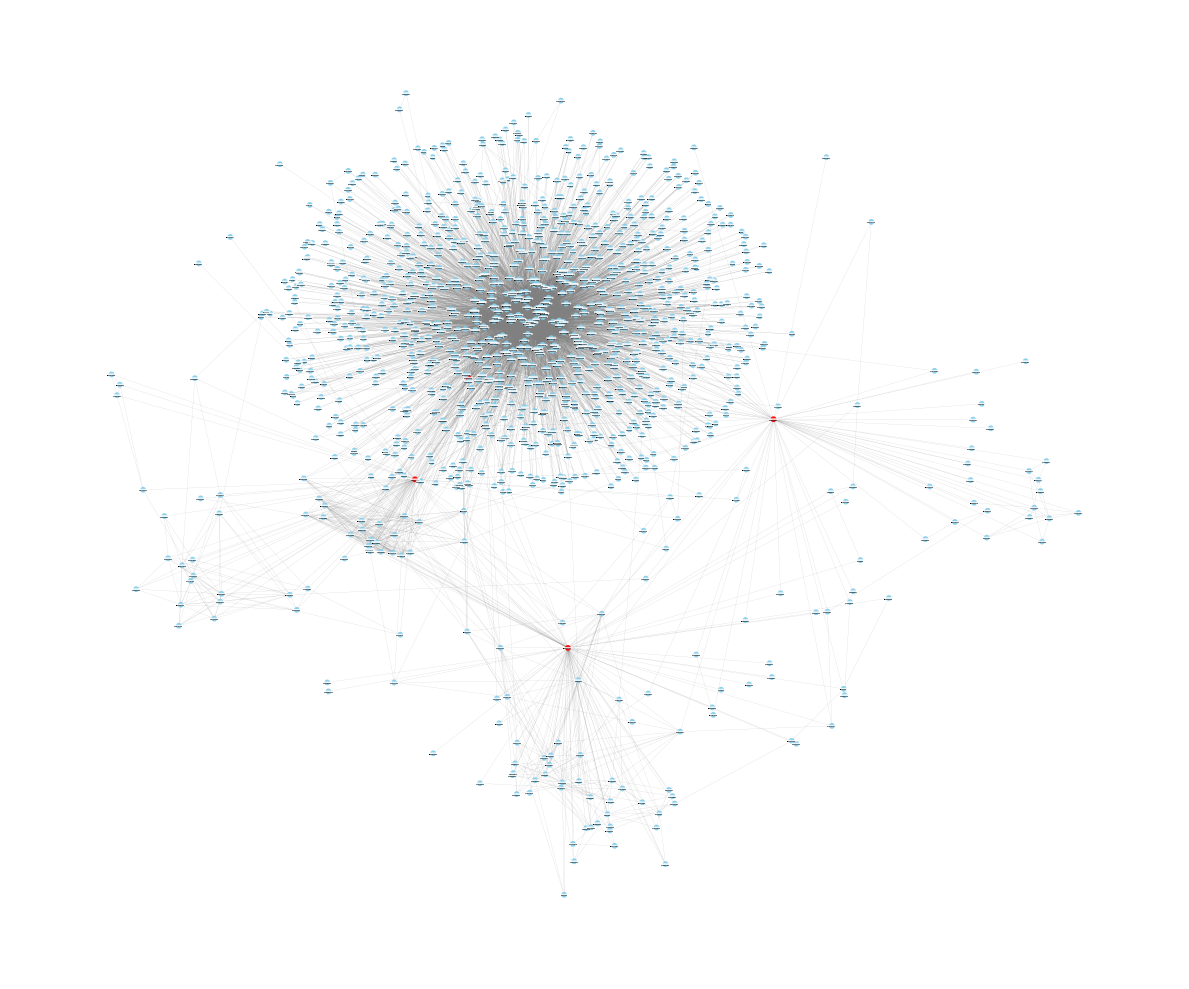

In [12]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)

node_colors = []
for node in G.nodes():
    if node in CONTRIBUTORS:
        node_colors.append("red")
    else:
        node_colors.append("skyblue")

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=10,
                       alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.6, width=0.1)
nx.draw_networkx_labels(G, pos, font_size=1, font_family='DejaVu Sans',
                       font_weight='bold', bbox=dict(boxstyle="round,pad=0.3",
                       facecolor="white", edgecolor="none", alpha=0.8))
plt.axis('off')
plt.tight_layout()
plt.savefig("graph.png", dpi=1000)
plt.show()

## Центральность по посредничеству

*Центральность по посредничеству (betweenness centrality)* — это показатель, который характеризует, насколько важную роль определённый узел играет на пути между другими узлами (определённый узел лежит на кратчайшем пути между двумя другими узлами).

Если у какого-либо узла высокий показатель центральности по посредничеству, тогда он — единственная связь между различными частями сети.

Узел с наибольшей степенью посредничества может контролировать наибольшее число каналов коммуникации.

Реализуем собственную функцию оценки центральности по посредничеству

In [13]:
def my_betweenness_centrality(G, endpoints=False):
    # Создаем словарь для хранения центральности каждого узла
    betweenness = {node: 0.0 for node in G.nodes()}
    nodes = list(G.nodes()) # Список узлов
    n = len(nodes) # Длина списка

    # Основной алгоритм
    for source in nodes:
        # Структура данных для обхода графа в ширину
        S = []  # Стек для порядка обхода
        dist = {source: 0}  # Расстояния
        sigma = defaultdict(int)  # Количество кратчайших путей
        sigma[source] = 1
        pred = defaultdict(list)  # Предшественники для каждого узла на кратчайших путях
        queue = deque([source])  # Очередь для алгоритма поиска в ширину

        # Процесс обхода в ширину
        while queue:
            # Обработка текущего узла
            current = queue.popleft()
            S.append(current)

            # Обход всех соседей
            for neighbor in G.neighbors(current):
                # Если узел встречается впервые
                if neighbor not in dist:
                    dist[neighbor] = dist[current] + 1 # Увеличиваем расстояние
                    queue.append(neighbor) # Добавляем в очередь

                # Если найден кратчайший путь
                if dist[neighbor] == dist[current] + 1:
                    sigma[neighbor] += sigma[current] # Увеличиваем количество путей
                    pred[neighbor].append(current) # Запоминаем предшественника

        # Обратный проход
        delta = defaultdict(float)
        # Идем от самых дальних узлов к источнику
        while S:
            current = S.pop()
            for predecessor in pred[current]:
                # "Вклад" пропорционально количеству путей
                # (Доля кратчайших путей через предшественника X "вклад" текущего узла)
                delta[predecessor] += (sigma[predecessor] / sigma[current]) * (1 + delta[current])
            #Добавляем вычисленный вклад в общую центральность узла
            if current != source:
                betweenness[current] += delta[current]
                # Учитываем все узлы, включая конечные точки путей
                if endpoints:
                    betweenness[current] += sigma[current]

    # Нормализация
    if n <= 2:
        scale = 1.0
    else:
        scale = 1.0 / ((n - 1) * (n - 2))

    # Нормализация результатов
    for node in betweenness:
        betweenness[node] *= scale

    return betweenness

Используем самописную функцию

In [14]:
test = my_betweenness_centrality(G)
test

{662741463: 0.003190815790351942,
 25891559: 0.002576505533326024,
 9030558: 0.04365395687314328,
 2774402: 5.7941829068089e-06,
 181226986: 0.007688141140403609,
 476551834: 3.363033800648177e-06,
 333156814: 0.049356753689610545,
 612347251: 9.221520608211348e-06,
 172710559: 0.0759041147109936,
 488243736: 0.09063625733244958,
 156110357: 0.0019671939686752194,
 171332234: 0.07106641213645384,
 119447546: 8.387070299515239e-05,
 260785266: 1.3895860291771756e-06,
 41501022: 0.029635340045982228,
 578981853: 1.0779501573461084e-05,
 124487696: 0.028648779187113258,
 689514484: 0.0,
 155805141: 0.000232403620970889,
 212397580: 1.4574672561785323e-05,
 32386739: 3.5958440282137077e-06,
 222699574: 3.7062434370464277e-06,
 219305476: 0.18067994278951466,
 213374483: 0.0,
 348609170: 1.0888220260151787e-05,
 88785305: 1.4130587661565196e-05,
 334025696: 0.04387654046007743,
 189695779: 0.001194126329339377,
 326866301: 0.07437445265334265,
 282677928: 0.010696585889330304,
 210930165: 0

Запуск алгоритма через готовую функцию (сверка результатов)

In [15]:
bc = nx.betweenness_centrality(G)

print("Центральность по посредничеству:")
for node, score in bc.items():
    print(f'{node}: {score}')

Центральность по посредничеству:
662741463: 0.003190815790351942
25891559: 0.002576505533326024
9030558: 0.04365395687314328
2774402: 5.7941829068089e-06
181226986: 0.007688141140403609
476551834: 3.363033800648177e-06
333156814: 0.049356753689610545
612347251: 9.221520608211348e-06
172710559: 0.0759041147109936
488243736: 0.09063625733244958
156110357: 0.0019671939686752194
171332234: 0.07106641213645384
119447546: 8.387070299515239e-05
260785266: 1.3895860291771756e-06
41501022: 0.029635340045982228
578981853: 1.0779501573461084e-05
124487696: 0.028648779187113258
689514484: 0.0
155805141: 0.000232403620970889
212397580: 1.4574672561785323e-05
32386739: 3.5958440282137077e-06
222699574: 3.7062434370464277e-06
219305476: 0.18067994278951466
213374483: 0.0
348609170: 1.0888220260151787e-05
88785305: 1.4130587661565196e-05
334025696: 0.04387654046007743
189695779: 0.001194126329339377
326866301: 0.07437445265334265
282677928: 0.010696585889330304
210930165: 0.0031840625622291353
6556541

Центральности авторов работы (самописная функция)

In [16]:
for user_id, user_name in CONTRIBUTORS.items():
  print(f"{user_name} -> {test[user_id]}")

Аршинов Владислав -> 0.09063625733244958
Елохин Валерий -> 0.056870977780732
Савин Даниил -> 0.07437445265334265
Якушенко Иван -> 0.18067994278951466


Центральности авторов работы (готовая функция)

In [17]:
for user_id, user_name in CONTRIBUTORS.items():
  print(f"{user_name} -> {bc[user_id]}")

Аршинов Владислав -> 0.09063625733244958
Елохин Валерий -> 0.056870977780732
Савин Даниил -> 0.07437445265334265
Якушенко Иван -> 0.18067994278951466


## Центральность по близости

Здесь будет написана своя функция по рассчету центральности по близости для графа. Центральность по близости — показатель того, насколько близко узел расположен к остальным узлам сети. В нашей ситуации центральность по близости показывает близость человека ко всем остальным пользователям в сети.

In [18]:
def custom_closeness_centrality(G):
    closeness = {}
    # Реализуем поиск в ширину для нахождения расстояний
    for node in G.nodes():
        # Словарь distances будет хранить расстояния от текущего узла до остальных
        distances = {node: 0}
        queue = [node]

        while queue:
            current = queue.pop(0)
            # Для текущего узла перебираем всех соседей
            for neighbor in G.neighbors(current):
                # Проверяем, не посещали ли мы уже этого соседа
                if neighbor not in distances:
                    # Записываем расстояние до соседа
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)

        # Считаем сумму всех расстояний
        total_distance = sum(distances.values())
        reachable_count = len(distances)

        # Рассчитываем центральность по формуле
        if total_distance > 0:
            closeness[node] = (reachable_count - 1) / total_distance
        else:
            closeness[node] = 0

    return closeness

Теперь считаем центральности через выше написанную функцию и встроенную функцию.

In [19]:
custom_close_centr = custom_closeness_centrality(G)
lib_close_centr = nx.closeness_centrality(G)

В этой ячейке выводим центральности авторов работы по библиотечной функции

In [20]:
for user_id, user_name in CONTRIBUTORS.items():
  print(f"{user_name}\t -> {lib_close_centr[user_id]}")

Аршинов Владислав	 -> 0.37034813925570226
Елохин Валерий	 -> 0.3670434265318263
Савин Даниил	 -> 0.3670434265318263
Якушенко Иван	 -> 0.5200168563000421


В этой ячейке выводим центральности авторов работы по собственной функции

In [21]:
for user_id, user_name in CONTRIBUTORS.items():
  print(f"{user_name} -> {custom_close_centr[user_id]}")

Аршинов Владислав -> 0.37034813925570226
Елохин Валерий -> 0.3670434265318263
Савин Даниил -> 0.3670434265318263
Якушенко Иван -> 0.5200168563000421
